# Bring data from 4 sources
- t2_merchant_features_part1
- t2_merchant_features_part2_cuisine
- t2_order_features
- t2_dominant_topic_merchant_features from X_train
- t2_dominant_topic_merchant_features from X_test

In [16]:
import pandas as pd
import pandas_gbq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold


In [17]:
# order features

t2_order_features = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/t2_order_features.csv")

# merchant features part 1
t2_merchant_features_part1 = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/t2_merchant_features_part1.csv")

# merchant features part 2
t2_merchant_features_part2_cuisines = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/t2_merchant_features_part2_cuisines.csv")

# orders with topic vectors
t2_orders_with_topic_vectors = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/order_topic_vector_wtavg_full.csv")




In [24]:
# dropping repeated columns
t2_order_features = t2_order_features.drop(['booking_date'], axis = 1)
t2_merchant_features_part2_cuisines = t2_merchant_features_part2_cuisines.drop(['merchant_id'], axis = 1)


In [20]:
t2_order_features.columns

Index(['order_no', 'booking_date', 'actual_t2_second', 'booking_hour',
       'dist_to_merch', 'booking_day', 'is_weekend', 'normalized_gmv',
       'is_sku_promo_order', 'is_voucher_order', 'demand_service_area_1w',
       'avg_gmv_service_area_1w', 'avg_t2_service_area_1w',
       'demand_service_area_1d', 'avg_gmv_service_area_1d',
       'avg_t2_service_area_1d', 'avg_t2_merchant_1m'],
      dtype='object')

In [21]:
t2_merchant_features_part1.columns

Index(['order_no', 'merchant_id', 'is_merchant_in_poi',
       'merchant_acceptance_flag', 'merchant_auto_accept_flag',
       'merchant_goresto_flag', 'merch_demand_same_hour_1m',
       'avg_gmv_same_hour_merchant_1m', 'avg_t2_same_hour_merchant_1m',
       'merch_demand_3h', 'avg_gmv_merchant_3h', 'avg_t2_merchant_3h',
       'merch_demand_1d', 'avg_gmv_merchant_1d', 'avg_t2_merchant_1d',
       'merch_demand_1w', 'avg_gmv_merchant_1w', 'avg_t2_merchant_1w',
       'merch_demand_3d', 'avg_t2_merchant_3d'],
      dtype='object')

In [22]:
t2_merchant_features_part2_cuisines.columns

Index(['order_no', 'total_active_item', 'avg_merchant_price',
       'is_in_shopping_mall', 'total_cuisine_cnt', 'primary_cuisine_demand_1d',
       'avg_gmv_primary_cuisine_1d', 'avg_t2_primary_cuisine_1d',
       'primary_cuisine_demand_1w', 'avg_gmv_primary_cuisine_1w',
       'avg_t2_primary_cuisine_1w', 'classification0', 'classification1',
       'classification2'],
      dtype='object')

In [25]:
# join datasets 

df0 = pd.merge(t2_order_features, t2_merchant_features_part1, how = 'left', on =['order_no'])
df1 = pd.merge(df0, t2_merchant_features_part2_cuisines, how = 'left', on = ['order_no'])
df2 = pd.merge(df1, t2_orders_with_topic_vectors, how = 'left', on = ['order_no'])

df2.columns

Index(['order_no', 'actual_t2_second', 'booking_hour', 'dist_to_merch',
       'booking_day', 'is_weekend', 'normalized_gmv', 'is_sku_promo_order',
       'is_voucher_order', 'demand_service_area_1w', 'avg_gmv_service_area_1w',
       'avg_t2_service_area_1w', 'demand_service_area_1d',
       'avg_gmv_service_area_1d', 'avg_t2_service_area_1d',
       'avg_t2_merchant_1m', 'merchant_id', 'is_merchant_in_poi',
       'merchant_acceptance_flag', 'merchant_auto_accept_flag',
       'merchant_goresto_flag', 'merch_demand_same_hour_1m',
       'avg_gmv_same_hour_merchant_1m', 'avg_t2_same_hour_merchant_1m',
       'merch_demand_3h', 'avg_gmv_merchant_3h', 'avg_t2_merchant_3h',
       'merch_demand_1d', 'avg_gmv_merchant_1d', 'avg_t2_merchant_1d',
       'merch_demand_1w', 'avg_gmv_merchant_1w', 'avg_t2_merchant_1w',
       'merch_demand_3d', 'avg_t2_merchant_3d', 'total_active_item',
       'avg_merchant_price', 'is_in_shopping_mall', 'total_cuisine_cnt',
       'primary_cuisine_demand_1d',

In [63]:
t2_orders_with_topic_vectors.columns

Index(['order_no', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5',
       'topic6', 'topic7', 'topic8', 'topic9', 'topic10', 'topic11', 'topic12',
       'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18',
       'topic19', 'topic20', 'topic21', 'topic22', 'topic23', 'topic24',
       'topic25', 'topic26', 'topic27', 'topic28', 'topic29', 'topic30',
       'topic31', 'topic32', 'topic33', 'topic34', 'dominant_topic'],
      dtype='object')

In [33]:
import math
def fix_domtopic(row):
    topic0 = row.topic0
    dominant_topic = row.dominant_topic
    if math.isnan(dominant_topic) == False:
        if int(dominant_topic) > 0:
            return dominant_topic
        elif int(dominant_topic) == 0 and topic0 > 0:
            return dominant_topic
        elif int(dominant_topic) == 0 and topic0 == 0:
            return np.nan

In [28]:
dominant_topic_merchant_features_with_train = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/dominant_topic_merchant_features_with_train.csv")
dominant_topic_features_with_train = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/dominant_topic_features_with_train.csv")


In [30]:
dominant_topic_merchant_features_with_train.columns

Index(['merchant_id', 'dominant_topic', 'dominant_topic_merchant_order_cnt',
       'dominant_topic_merchant_average_t2_second'],
      dtype='object')

In [31]:
df3 = pd.merge(df2, dominant_topic_merchant_features_with_train, how = 'left', on = ['dominant_topic', 'merchant_id'])
df3

,order_no,actual_t2_second,booking_hour,dist_to_merch,booking_day,is_weekend,normalized_gmv,is_sku_promo_order,is_voucher_order,demand_service_area_1w,...,topic28,topic29,topic30,topic31,topic32,topic33,topic34,dominant_topic,dominant_topic_merchant_order_cnt,dominant_topic_merchant_average_t2_second
0,F-914203374,1248,18,0.045,5,0,175000.0,1,0,124461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F-914261757,1323,19,0.055,5,0,66000.0,1,1,99864,...,0.000091,0.000102,0.000064,0.000142,0.000069,0.000480,0.000141,2.0,53.0,600.509434
2,F-914010922,336,15,0.243,5,0,13750.0,0,0,400348,...,0.003244,0.003639,0.002275,0.005052,0.002462,0.017089,0.005021,25.0,52.0,686.480769
3,F-913711100,78,11,0.103,5,0,42000.0,0,0,445922,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
4,F-913943155,179,14,0.448,5,0,27000.0,0,0,4432,...,0.000089,0.000099,0.579161,0.138071,0.000067,0.000466,0.000137,3.0,1.0,179.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594422,F-908812314,1048,18,0.130,6,1,98502.0,0,0,2343323,...,0.001572,0.000030,0.035711,0.021093,0.041972,0.000139,0.000041,23.0,108.0,1243.685185
1594423,F-908344718,1316,11,0.264,6,1,128000.0,0,0,2343323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1594424,F-909028301,623,20,0.341,6,1,27500.0,1,1,2343323,...,0.000038,0.000042,0.117970,0.055561,0.053701,0.000199,0.000059,14.0,4.0,574.750000
1594425,F-908888040,1470,18,0.291,6,1,49000.0,0,0,2343323,...,0.000903,0.001013,0.000633,0.001407,0.000686,0.004759,0.001398,10.0,58.0,302.379310


In [12]:
df3.isnull().sum()*100/len(df3)


order_no                                      0.000000
booking_date                                  0.000000
actual_t2_second                              0.000000
booking_hour                                  0.000000
dist_to_merch                                 0.000000
                                               ...    
topic33                                       8.273066
topic34                                       8.273066
dominant_topic                               29.234954
dominant_topic_merchant_order_cnt            42.164364
dominant_topic_merchant_average_t2_second    42.164364
Length: 87, dtype: float64

In [14]:
map_dtcnt = df3['dominant_topic'].map(dominant_topic_features_with_train.set_index('dominant_topic')['dominant_topic_order_cnt'])
df3['dominant_topic_merchant_order_cnt'] = df3['dominant_topic_merchant_order_cnt'].fillna(map_dtcnt/dominant_topic_merchant_features_with_train.merchant_id.nunique())

map_dtt2 = df3['dominant_topic'].map(dominant_topic_features_with_train.set_index('dominant_topic')['dominant_topic_average_t2_second'])
df3['dominant_topic_merchant_average_t2_second'] = df3['dominant_topic_merchant_average_t2_second'].fillna(map_dtt2)

df3


,order_no,booking_date,actual_t2_second,booking_hour,dist_to_merch,booking_day,is_weekend,normalized_gmv,is_sku_promo_order,is_voucher_order,...,topic28,topic29,topic30,topic31,topic32,topic33,topic34,dominant_topic,dominant_topic_merchant_order_cnt,dominant_topic_merchant_average_t2_second
0,F-914203374,2020-07-17,1248,18,0.045,5,0,175000.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F-914261757,2020-07-17,1323,19,0.055,5,0,66000.0,1,1,...,0.000091,0.000102,0.000064,0.000142,0.000069,0.000480,0.000141,2.0,53.0,600.509434
2,F-914010922,2020-07-17,336,15,0.243,5,0,13750.0,0,0,...,0.003244,0.003639,0.002275,0.005052,0.002462,0.017089,0.005021,25.0,52.0,686.480769
3,F-913711100,2020-07-17,78,11,0.103,5,0,42000.0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
4,F-913943155,2020-07-17,179,14,0.448,5,0,27000.0,0,0,...,0.000089,0.000099,0.579161,0.138071,0.000067,0.000466,0.000137,3.0,1.0,179.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594422,F-908812314,2020-07-11,1048,18,0.130,6,1,98502.0,0,0,...,0.001572,0.000030,0.035711,0.021093,0.041972,0.000139,0.000041,23.0,108.0,1243.685185
1594423,F-908344718,2020-07-11,1316,11,0.264,6,1,128000.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1594424,F-909028301,2020-07-11,623,20,0.341,6,1,27500.0,1,1,...,0.000038,0.000042,0.117970,0.055561,0.053701,0.000199,0.000059,14.0,4.0,574.750000
1594425,F-908888040,2020-07-11,1470,18,0.291,6,1,49000.0,0,0,...,0.000903,0.001013,0.000633,0.001407,0.000686,0.004759,0.001398,10.0,58.0,302.379310


In [34]:
df3['dominant_topic'] = df3[['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5',
   'topic6', 'topic7', 'topic8', 'topic9', 'topic10', 'topic11', 'topic12',
   'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18',
   'topic19', 'topic20', 'topic21', 'topic22', 'topic23', 'topic24',
   'topic25', 'topic26', 'topic27', 'topic28', 'topic29', 'topic30',
   'topic31', 'topic32', 'topic33', 'topic34']].idxmax(axis=1).str.lstrip('topic')

df3['dominant_topic'] = pd.to_numeric(df3['dominant_topic'])

# correct dominant topic
df3['dominant_topic'] = df3[['topic0', 'dominant_topic']].apply(fix_domtopic, axis =1)


In [35]:
np.mean(df3.dominant_topic_merchant_order_cnt)

37.91393779950485

In [36]:
df3.to_csv("/Users/tamanna.urmi/ETA_at_checkout/t2_dataset_with_traindtfeat.csv", index = False)

# split the dataset

In [88]:

test_size = 0.2 
pre_X = df1

pre_X_train, pre_X_test = train_test_split(pre_X, test_size=test_size, random_state=42)
# X_train = pre_X_train.drop(['merchant_id', 'customer_id', 'book_time', 'ids_by_hour', 'booking_date', 'actual_t2_second'], axis = 1)
# X_test = pre_X_test.drop(['merchant_id', 'customer_id', 'book_time', 'ids_by_hour', 'booking_date', 'actual_t2_second'], axis = 1)




# Create dataset with dominant topic features

In [35]:
orders_tv_with_merchant_tv_final = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/orders_tv_with_merchant_tv_final.csv")


In [96]:
# separate train and test to fetch dominant topic features separately
X_train_orders = pre_X_train[['order_no']]
X_test_orders = pre_X_test[['order_no']]

# topic features with right train and test split. This is a preparation for dominant topic features

t2_order_topicfeat_train = pd.merge(X_train_orders, orders_tv_with_merchant_tv_final, how = 'inner', on = 'order_no')
t2_order_topicfeat_test = pd.merge(X_test_orders, orders_tv_with_merchant_tv_final, how = 'inner', on = 'order_no')

print(t2_order_topicfeat_train.shape)
print(t2_order_topicfeat_test.shape)
t2_order_topicfeat_test

(1170672, 43)
(292533, 43)


,order_no,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,...,topic32,topic33,topic34,dominant_topic,merchant_id,actual_t2_second,arrival_merchant_distance,mdominant_topic,omtopic0,omdominant_topic
0,F-899905755,0.000014,0.000008,0.000012,0.000027,0.000026,0.000005,0.000013,0.000035,0.000030,...,0.000009,0.000061,0.000018,24.0,542718026,97,29.197501,24,-0.294055,24
1,F-920581288,0.493525,0.000286,0.000433,0.000968,0.000915,0.001869,0.000455,0.001246,0.001087,...,0.000314,0.002178,0.000640,0.0,542882769,968,1.822173,5,0.401427,12
2,F-900821647,0.001061,0.000617,0.000934,0.002087,0.001973,0.000349,0.490756,0.002686,0.002344,...,0.000677,0.004696,0.001380,6.0,543095046,296,14.434511,22,-0.009635,6
3,F-906918801,0.004661,0.002711,0.004101,0.009169,0.008667,0.001535,0.004310,0.011800,0.010296,...,0.002973,0.020632,0.006062,30.0,542887725,114,9.435382,30,-0.004645,30
4,F-908726196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,542547857,31,5.508909,5,-0.025524,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292528,F-892217781,0.000628,0.639171,0.000552,0.001235,0.001167,0.001268,0.000580,0.001589,0.001386,...,0.000400,0.002778,0.000816,1.0,542580008,1267,93.534456,27,-0.008792,1
292529,F-914705047,0.004322,0.000056,0.027606,0.000188,0.000178,0.000031,0.000088,0.000242,0.000211,...,0.000061,0.000423,0.000124,30.0,543100052,182,9.625985,5,-0.005247,30
292530,F-897321552,0.000024,0.000014,0.000021,0.000047,0.000045,0.000008,0.000022,0.000061,0.000053,...,0.000015,0.000106,0.000031,24.0,542679470,474,13.958354,5,-0.007245,24
292531,F-926530246,0.000008,0.002541,0.001091,0.009215,0.000015,0.320986,0.000007,0.001474,0.000018,...,0.002976,0.000035,0.000010,5.0,543225753,1624,2.428211,5,-0.025516,5


In [97]:
# Train set with pre-features
df_dom_train = t2_order_topicfeat_train.drop(['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5',
       'topic6', 'topic7', 'topic8', 'topic9', 'topic10', 'topic11', 'topic12',
       'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18',
       'topic19', 'topic20', 'topic21', 'topic22', 'topic23', 'topic24',
       'topic25', 'topic26', 'topic27', 'topic28', 'topic29', 'topic30',
       'topic31', 'topic32', 'topic33', 'topic34',
       'arrival_merchant_distance', 'mdominant_topic', 'omtopic0',
       'omdominant_topic'], axis = 1)

# Test set with pre-features
df_dom_test = t2_order_topicfeat_test.drop(['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5',
       'topic6', 'topic7', 'topic8', 'topic9', 'topic10', 'topic11', 'topic12',
       'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18',
       'topic19', 'topic20', 'topic21', 'topic22', 'topic23', 'topic24',
       'topic25', 'topic26', 'topic27', 'topic28', 'topic29', 'topic30',
       'topic31', 'topic32', 'topic33', 'topic34', 
       'arrival_merchant_distance', 'mdominant_topic', 'omtopic0',
       'omdominant_topic'], axis = 1)

#dominant topic aggregated features with train and test separated
dominant_topic_features_train = df_dom_train[["order_no", "actual_t2_second", "merchant_id", "dominant_topic"]]\
.groupby(["merchant_id", "dominant_topic"])\
.agg({'order_no':'count', 'actual_t2_second':'mean'})\
.rename(columns={'order_no': 'dominant_topic_order_cnt', 'actual_t2_second':'dominant_topic_average_t2_second'})\
.reset_index()

dominant_topic_features_test = df_dom_test[["order_no", "actual_t2_second", "merchant_id", "dominant_topic"]]\
.groupby(["merchant_id", "dominant_topic"])\
.agg({'order_no':'count', 'actual_t2_second':'mean'})\
.rename(columns={'order_no': 'dominant_topic_order_cnt', 'actual_t2_second':'dominant_topic_average_t2_second'})\
.reset_index()

print(dominant_topic_features_train.shape)
print(dominant_topic_features_test.shape)


(336330, 4)
(135596, 4)


In [107]:
# merging dominant topic features to full topics dataset

t2_orders_with_alltopic_features_train = pd.merge(t2_order_topicfeat_train, dominant_topic_features_train, how='left', on = ['merchant_id', 'dominant_topic'])
t2_orders_with_alltopic_features_train = t2_orders_with_alltopic_features_train.drop(['actual_t2_second', 'merchant_id'], axis = 1)
#orders_with_domtopic_features_train.to_csv("/Users/tamanna.urmi/ETA_at_checkout/order_with_domtopic_features_train.csv", index = False)

t2_orders_with_alltopic_features_test = pd.merge(t2_order_topicfeat_test, dominant_topic_features_test, how='left', on = ['merchant_id', 'dominant_topic'])
t2_orders_with_alltopic_features_test = t2_orders_with_alltopic_features_test.drop(['actual_t2_second', 'merchant_id'], axis = 1)
#orders_with_domtopic_features_test.to_csv("/Users/tamanna.urmi/ETA_at_checkout/order_with_domtopic_features_test.csv", index = False)

print("X_train shape: ", pre_X_train.shape)
print("With features X_train shape: ", t2_orders_with_domtopic_features_train.shape)
print("Unique order count before dominant topic: ", pre_X_train.order_no.nunique(), ", After dominant topic: ", t2_orders_with_domtopic_features_train.order_no.nunique())
print("X_train shape: ", pre_X_test.shape)
print("With features X_test shape: ", t2_orders_with_domtopic_features_test.shape)
print("Unique order count before dominant topic: ", pre_X_test.order_no.nunique(), ", After dominant topic: ", t2_orders_with_domtopic_features_test.order_no.nunique())
t2_orders_with_alltopic_features_test


X_train shape:  (1275541, 54)
With features X_train shape:  (1170672, 45)
Unique order count before dominant topic:  1275332 , After dominant topic:  1169923
X_train shape:  (318886, 54)
With features X_test shape:  (292533, 45)
Unique order count before dominant topic:  318873 , After dominant topic:  292374


,order_no,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,...,topic32,topic33,topic34,dominant_topic,arrival_merchant_distance,mdominant_topic,omtopic0,omdominant_topic,dominant_topic_order_cnt,dominant_topic_average_t2_second
0,F-899905755,0.000014,0.000008,0.000012,0.000027,0.000026,0.000005,0.000013,0.000035,0.000030,...,0.000009,0.000061,0.000018,24.0,29.197501,24,-0.294055,24,1.0,97.000000
1,F-920581288,0.493525,0.000286,0.000433,0.000968,0.000915,0.001869,0.000455,0.001246,0.001087,...,0.000314,0.002178,0.000640,0.0,1.822173,5,0.401427,12,1.0,968.000000
2,F-900821647,0.001061,0.000617,0.000934,0.002087,0.001973,0.000349,0.490756,0.002686,0.002344,...,0.000677,0.004696,0.001380,6.0,14.434511,22,-0.009635,6,1.0,296.000000
3,F-906918801,0.004661,0.002711,0.004101,0.009169,0.008667,0.001535,0.004310,0.011800,0.010296,...,0.002973,0.020632,0.006062,30.0,9.435382,30,-0.004645,30,9.0,272.666667
4,F-908726196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,5.508909,5,-0.025524,33,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292528,F-892217781,0.000628,0.639171,0.000552,0.001235,0.001167,0.001268,0.000580,0.001589,0.001386,...,0.000400,0.002778,0.000816,1.0,93.534456,27,-0.008792,1,1.0,1267.000000
292529,F-914705047,0.004322,0.000056,0.027606,0.000188,0.000178,0.000031,0.000088,0.000242,0.000211,...,0.000061,0.000423,0.000124,30.0,9.625985,5,-0.005247,30,1.0,182.000000
292530,F-897321552,0.000024,0.000014,0.000021,0.000047,0.000045,0.000008,0.000022,0.000061,0.000053,...,0.000015,0.000106,0.000031,24.0,13.958354,5,-0.007245,24,2.0,577.500000
292531,F-926530246,0.000008,0.002541,0.001091,0.009215,0.000015,0.320986,0.000007,0.001474,0.000018,...,0.002976,0.000035,0.000010,5.0,2.428211,5,-0.025516,5,1.0,1624.000000


In [109]:
## 

# Combine dominant topic features, topics with rest of the training set and testing set

train_full = pd.merge(pre_X_train, t2_orders_with_alltopic_features_train, how = 'inner', on =['order_no'])
test_full = pd.merge(pre_X_test, t2_orders_with_alltopic_features_test, how = 'inner', on =['order_no'])

# create final X_train, X_test, y_train, y_test
X_train = train_full.drop(['order_no', 'classification', 'omtopic0', 'merchant_id', 'actual_t2_second', \
                           'arrival_merchant_distance', 'mdominant_topic', 'omdominant_topic',\
                           'customer_id', 'book_time', 'ids_by_hour', 'booking_date'], axis = 1)
X_test = test_full.drop(['order_no', 'classification', 'omtopic0', 'merchant_id', 'actual_t2_second', \
                         'arrival_merchant_distance', 'mdominant_topic', 'omdominant_topic', \
                         'customer_id', 'book_time', 'ids_by_hour', 'booking_date'], axis = 1)
y_train = train_full[['actual_t2_second']]
y_test = test_full[['actual_t2_second']]

print("Full training set shape: ", train_full.shape)
print("Full testing set shape: ", test_full.shape)
print("Full X_train shape: ", X_train.shape)
print("Full X_test shape: ", X_test.shape)
print("Full y_train shape: ", y_train.shape)
print("Full y_test shape: ", y_test.shape)

Full training set shape:  (1171520, 96)
Full testing set shape:  (292585, 96)
Full X_train shape:  (1171520, 84)
Full X_test shape:  (292585, 84)
Full y_train shape:  (1171520, 1)
Full y_test shape:  (292585, 1)


In [110]:
nullXtr = pd.DataFrame((X_train.isnull().sum()*100/len(X_train_full))>0, columns = ['nullhigh'])
nullXtr[(nullXtr.nullhigh==True)].index

Index(['avg_t2_merchant_1m', 'is_merchant_in_poi', 'merchant_acceptance_flag',
       'merchant_auto_accept_flag', 'merchant_goresto_flag',
       'merch_demand_same_hour_1m', 'avg_gmv_same_hour_merchant_1m',
       'avg_t2_same_hour_merchant_1m', 'merch_demand_3h',
       'avg_gmv_merchant_3h', 'avg_t2_merchant_3h', 'merch_demand_1d',
       'avg_gmv_merchant_1d', 'avg_t2_merchant_1d', 'merch_demand_1w',
       'avg_gmv_merchant_1w', 'avg_t2_merchant_1w', 'merch_demand_3d',
       'avg_t2_merchant_3d', 'total_active_item', 'avg_merchant_price',
       'is_in_shopping_mall', 'total_cuisine_cnt', 'primary_cuisine_demand_1d',
       'avg_gmv_primary_cuisine_1d', 'avg_t2_primary_cuisine_1d',
       'primary_cuisine_demand_1w', 'avg_gmv_primary_cuisine_1w',
       'avg_t2_primary_cuisine_1w', 'classification0', 'classification1',
       'classification2', 'dominant_topic', 'dominant_topic_order_cnt',
       'dominant_topic_average_t2_second'],
      dtype='object')

In [111]:
X_train[['avg_t2_merchant_1m', 'is_merchant_in_poi', 'merchant_acceptance_flag',
       'merchant_auto_accept_flag', 'merchant_goresto_flag',
       'merch_demand_same_hour_1m', 'avg_gmv_same_hour_merchant_1m',
       'avg_t2_same_hour_merchant_1m', 'merch_demand_3h',
       'avg_gmv_merchant_3h', 'avg_t2_merchant_3h', 'merch_demand_1d',
       'avg_gmv_merchant_1d', 'avg_t2_merchant_1d', 'merch_demand_1w',
       'avg_gmv_merchant_1w', 'avg_t2_merchant_1w', 'merch_demand_3d',
       'avg_t2_merchant_3d', 'total_active_item', 'avg_merchant_price',
       'is_in_shopping_mall', 'total_cuisine_cnt', 'primary_cuisine_demand_1d',
       'avg_gmv_primary_cuisine_1d', 'avg_t2_primary_cuisine_1d',
       'primary_cuisine_demand_1w', 'avg_gmv_primary_cuisine_1w',
       'avg_t2_primary_cuisine_1w', 'classification0', 'classification1',
       'classification2', 'dominant_topic', 'dominant_topic_order_cnt',
       'dominant_topic_average_t2_second']].isnull().sum()*100/len(X_train)

avg_t2_merchant_1m                   0.098419
is_merchant_in_poi                  18.359482
merchant_acceptance_flag            18.359482
merchant_auto_accept_flag           18.359482
merchant_goresto_flag               18.359482
merch_demand_same_hour_1m           21.258365
avg_gmv_same_hour_merchant_1m       21.258365
avg_t2_same_hour_merchant_1m        21.258877
merch_demand_3h                     44.783102
avg_gmv_merchant_3h                 44.783102
avg_t2_merchant_3h                  44.783871
merch_demand_1d                     26.509407
avg_gmv_merchant_1d                 26.509407
avg_t2_merchant_1d                  26.510858
merch_demand_1w                     19.162456
avg_gmv_merchant_1w                 19.162456
avg_t2_merchant_1w                  19.162626
merch_demand_3d                     20.467427
avg_t2_merchant_3d                  20.468110
total_active_item                   18.359482
avg_merchant_price                  18.359482
is_in_shopping_mall               

In [113]:
X_train.to_csv("/Users/tamanna.urmi/ETA_at_checkout/X_train.csv", index = False)
X_test.to_csv("/Users/tamanna.urmi/ETA_at_checkout/X_test.csv", index = False)
y_train.to_csv("/Users/tamanna.urmi/ETA_at_checkout/y_train.csv", index = False)
y_test.to_csv("/Users/tamanna.urmi/ETA_at_checkout/y_test.csv", index = False)


In [5]:
X_train = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/X_train.csv")
X_test = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/X_test.csv")
y_train = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/y_train.csv")
y_test = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/y_test.csv")

In [6]:
nullXtrn = pd.DataFrame((X_train.isnull().sum()*100/len(X_train))>0, columns = ['nullhigh'])
colstrn = nullXtrn[(nullXtrn.nullhigh==True)].index

for col in colstrn:
#     print('start', col)
    X_train[col] = X_train[col].fillna(X_train[col].mean())
    
nullXtst = pd.DataFrame((X_test.isnull().sum()*100/len(X_test))>0, columns = ['nullhigh'])
colstst = nullXtst[(nullXtst.nullhigh==True)].index

for col in colstst:
    X_test[col] = X_test[col].fillna(X_train[col].mean())


    
b_train = X_train[['avg_t2_merchant_1m']]
b_test = X_test[['avg_t2_merchant_1m']]


In [7]:
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_train.mean())

In [4]:
nullXt = pd.DataFrame((X_train.isnull().sum()*100/len(X_train))>0, columns = ['nullhigh'])
nullXt[(nullXt.nullhigh==True)].index


Index([], dtype='object')

# Models

In [4]:
## Error definitions

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def mape(y_true, y_pred):
  return np.mean(abs(y_pred - y_true)*100/(y_true))

def error_grid(y_true, y_pred):
    print("Model MAE : ", mean_absolute_error(y_true, y_pred))
    print("Model MSE : ", mean_squared_error(y_true, y_pred))
    print("Model R2 : ", r2_score(y_true, y_pred))
    print("Model RMSE : ", mean_squared_error(y_true, y_pred, squared=False))
#     print("Model MAPE : ", mape(y_true.values, y_pred), "\n")

In [123]:
## Linear regression

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

## To retrieve the intercept:
# print('Regressor Intercept:',regressor.intercept_)
## For retrieving the slope:
# print('Regressor Coefficient:',regressor.coef_)

y_predLR = regressor.predict(X_test)
y_predLR_df = pd.DataFrame(y_predLR, index = y_test.index)
y_resultLR = pd.concat([y_test, y_predLR_df], axis = 1)
y_resultLR

,actual_t2_second,0
0,97,41.937659
1,968,995.031495
2,296,267.305411
3,114,268.121898
4,31,193.826663
...,...,...
292580,1267,1076.126846
292581,182,461.131049
292582,474,551.986160
292583,1624,1491.355445


In [132]:
# LR1 
print("Model:")
error_grid(y_test, y_predLR)
print("Baseline:")
error_grid(y_test, b_test.values)

Model:
Model MAE :  191.98387702904142
Model MSE :  80005.19992475174
Model R2 :  0.6357718765329723
Model RMSE :  282.8519045803859
Model MAPE :  81.3299665944663 

Baseline:
Model MAE :  251.49297837806287
Model MSE :  128436.67334014842
Model R2 :  0.4152848994936743
Model RMSE :  358.380626345996
Model MAPE :  102.88513898544547 



In [7]:
X_trainx = X_train.drop(['merchant_acceptance_flag', 'merchant_auto_accept_flag', 'merchant_goresto_flag'], axis=1)
X_testx = X_test.drop(['merchant_acceptance_flag', 'merchant_auto_accept_flag', 'merchant_goresto_flag'], axis=1)

## XGB 1
xgb1_cnf = XGBRegressor(learning_rate=0.02, objective ='reg:squarederror', max_depth = 6, colsample_bytree = 0.8,\
                     nthread=1, alpha = 10, n_estimators = 200)

xgb1 = xgb1_cnf.fit(X_trainx, y_train)
y_predxgb1 = xgb1.predict(X_testx)
y_predxgb1_df = pd.DataFrame(y_predxgb1, index = y_test.index)


print("Model:")
error_grid(y_test, y_predxgb1)

# print('Model Mean Absolute Percentage Error:', np.mean((y2_predxgb_df.values - y2_test)/y2_test) * 100)

Model:
Model MAE :  156.7607648392867
Model MSE :  66202.64269613447
Model R2 :  0.6986087861732693
Model RMSE :  257.2987421192231


In [11]:
np.mean((y_predxgb1_df.values - y_test)/y_test) * 100

actual_t2_second    43.85856
dtype: float64

In [12]:

## XGB 2
xgb2_cnf = XGBRegressor(learning_rate=0.02, max_depth = 8, objective ='reg:squarederror', \
                        colsample_bytree = 0.7, subsample = 0.8, n_estimators = 300)

xgb2 = xgb2_cnf.fit(X_trainx, y_train)
y_predxgb2 = xgb2.predict(X_testx)
y_predxgb2_df = pd.DataFrame(y_predxgb2, index = y_test.index)


print("Model:")
error_grid(y_test, y_predxgb2)
print("Model MAPE: ", np.mean((y_predxgb2_df.values - y_test)/y_test) * 100)
# print("Baseline:")
# error_grid(y_test, b_test.values)




Model:
Model MAE :  156.7607648392867
Model MSE :  66202.64269613447
Model R2 :  0.6986087861732693
Model RMSE :  257.2987421192231
Model MAPE:  actual_t2_second    43.490903
dtype: float64


In [13]:
error_grid(y_test, y_predxgb2)

Model MAE :  152.86776195301675
Model MSE :  64111.86450869221
Model R2 :  0.7081271701847351
Model RMSE :  253.20320793523177


# Feature importance

In [14]:
import eli5
from eli5.sklearn import PermutationImportance

/Users/tamanna.urmi/virtualenv/gojek_feast/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/tamanna.urmi/virtualenv/gojek_feast/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [16]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb2_cnf, random_state=1).fit(X_testx, y_test)
a = eli5.show_weights(perm, feature_names = X_testx.columns.tolist())
a

Weight,Feature
0.9520 ± 0.0020,dominant_topic_average_t2_second
0.1113 ± 0.0017,avg_t2_merchant_1m
0.0910 ± 0.0015,normalized_gmv
0.0160 ± 0.0004,avg_gmv_merchant_1w
0.0155 ± 0.0003,dominant_topic_order_cnt
0.0080 ± 0.0002,avg_t2_merchant_3h
0.0053 ± 0.0002,avg_t2_same_hour_merchant_1m
0.0024 ± 0.0001,topic1
0.0018 ± 0.0001,avg_t2_merchant_1w
0.0016 ± 0.0001,booking_hour


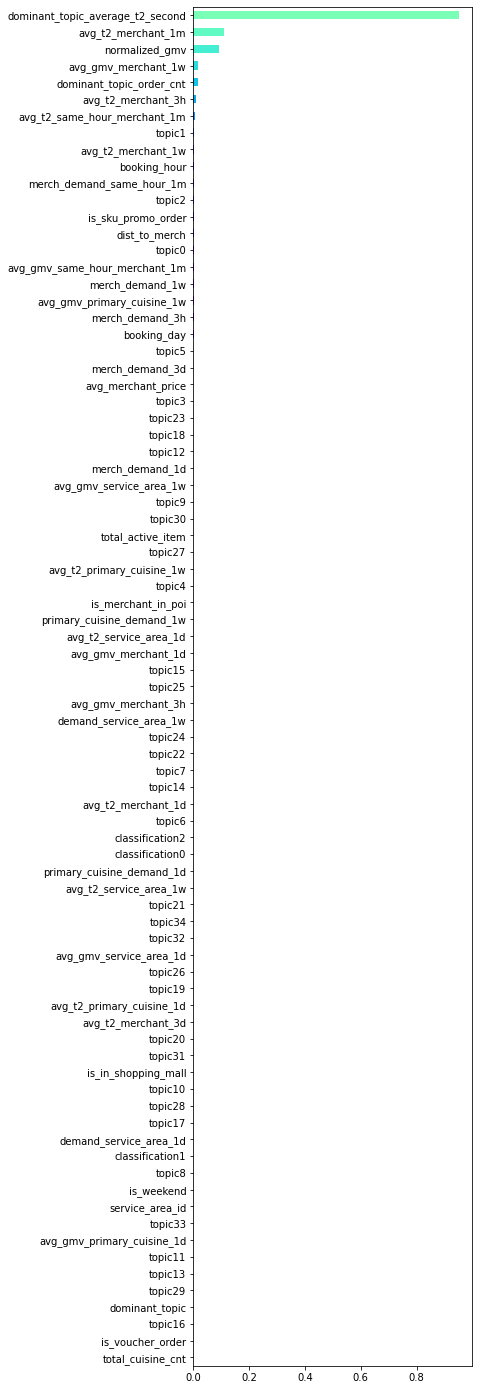

In [17]:
import random
from matplotlib.pyplot import cm
import numpy as np

plt.figure(figsize=(5,25))
importances = pd.Series(perm.feature_importances_, X_trainx.columns)
importances.sort_values().plot.barh(color = iter(cm.rainbow(np.linspace(-1.1,1.5))));

In [18]:
X_trainx.columns

Index(['service_area_id', 'booking_hour', 'dist_to_merch', 'booking_day',
       'is_weekend', 'normalized_gmv', 'is_sku_promo_order',
       'is_voucher_order', 'demand_service_area_1w', 'avg_gmv_service_area_1w',
       'avg_t2_service_area_1w', 'demand_service_area_1d',
       'avg_gmv_service_area_1d', 'avg_t2_service_area_1d',
       'avg_t2_merchant_1m', 'is_merchant_in_poi', 'merch_demand_same_hour_1m',
       'avg_gmv_same_hour_merchant_1m', 'avg_t2_same_hour_merchant_1m',
       'merch_demand_3h', 'avg_gmv_merchant_3h', 'avg_t2_merchant_3h',
       'merch_demand_1d', 'avg_gmv_merchant_1d', 'avg_t2_merchant_1d',
       'merch_demand_1w', 'avg_gmv_merchant_1w', 'avg_t2_merchant_1w',
       'merch_demand_3d', 'avg_t2_merchant_3d', 'total_active_item',
       'avg_merchant_price', 'is_in_shopping_mall', 'total_cuisine_cnt',
       'primary_cuisine_demand_1d', 'avg_gmv_primary_cuisine_1d',
       'avg_t2_primary_cuisine_1d', 'primary_cuisine_demand_1w',
       'avg_gmv_primary_cuis

In [8]:
xgb3_cnf = XGBRegressor(learning_rate=0.02, max_depth = 8, objective ='reg:squarederror', \
                        colsample_bytree = 0.7, subsample = 0.8, n_estimators = 300)

X_train3 = X_train[['dominant_topic_average_t2_second', 'avg_t2_merchant_1m', 'normalized_gmv', 'dominant_topic_order_cnt',\
                    'avg_gmv_merchant_1w', 'avg_t2_merchant_3h']]
X_test3 = X_test[['dominant_topic_average_t2_second', 'avg_t2_merchant_1m', 'normalized_gmv', 'dominant_topic_order_cnt',\
                    'avg_gmv_merchant_1w', 'avg_t2_merchant_3h']]
xgb3 = xgb3_cnf.fit(X_train3, y_train)
y_predxgb3 = xgb3.predict(X_test3)
y_predxgb3_df = pd.DataFrame(y_predxgb3, index = y_test.index)


print("Model:")
error_grid(y_test, y_predxgb3)
print("Model MAPE: ", np.mean((y_predxgb3_df.values - y_test)/y_test) * 100)

Model:
Model MAE :  153.07448745008628
Model MSE :  65610.44047723948
Model R2 :  0.7013048197198888
Model RMSE :  256.14535029400685
Model MAPE:  actual_t2_second    43.551633
dtype: float64


# validation

In [2]:
dval = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/current_model_predictions.csv")
dval = dval.dropna()
print(dval.shape)

(21937374, 2)


In [9]:
# Out of time validation

val_fulldataset = pd.read_csv("/Users/tamanna.urmi/ETA_at_checkout/validation_full_dataset.csv")
val_dataset = val_fulldataset[['dominant_topic_average_t2_second', 'avg_t2_merchant_1m', 'normalized_gmv', 'dominant_topic_order_cnt',\
                    'avg_gmv_merchant_1w', 'avg_t2_merchant_3h']]

In [10]:
nullXtrn = pd.DataFrame((X_train.isnull().sum()*100/len(X_train))>0, columns = ['nullhigh'])
colstrn = nullXtrn[(nullXtrn.nullhigh==True)].index

for col in colstrn:
#     print('start', col)
    X_train[col] = X_train[col].fillna(X_train[col].mean())
    
nullXtst = pd.DataFrame((val_dataset.isnull().sum()*100/len(val_dataset))>0, columns = ['nullhigh'])
colstst = nullXtst[(nullXtst.nullhigh==True)].index

for col in colstst:
    val_dataset[col] = val_dataset[col].fillna(X_train[col].mean())



/Users/tamanna.urmi/virtualenv/gojek_feast/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [11]:
y_valtest = val_fulldataset[['actual_t2_second']]
y_valtest = y_valtest.fillna(y_train.mean())

In [17]:
val_dataset.isnull().sum()

dominant_topic_average_t2_second    0
avg_t2_merchant_1m                  0
normalized_gmv                      0
dominant_topic_order_cnt            0
avg_gmv_merchant_1w                 0
avg_t2_merchant_3h                  0
dtype: int64

In [21]:
y_valtest.isnull().sum()

actual_t2_second    0
dtype: int64

In [15]:

y_valpredxgb3 = xgb3.predict(val_dataset)
y_valpredxgb3_df = pd.DataFrame(y_valpredxgb3, index = y_valtest.index)


print("Validation set errors: ")
error_grid(y_valtest, y_valpredxgb3)
print("Model MAPE: ", np.mean((y_valpredxgb3_df.values - y_valtest)/y_valtest) * 100)

Validation set errors: 
Model MAE :  212.84244654174867
Model MSE :  109228.85350179483
Model R2 :  0.5676484491530689
Model RMSE :  330.4978872879444
Model MAPE:  actual_t2_second    56.863998
dtype: float64


In [13]:
val_fulldataset["order_no"]

0         F-949956618
1         F-949748972
2         F-949829025
3         F-949365659
4         F-949426174
             ...     
894415    F-953025266
894416    F-953629915
894417    F-953492825
894418    F-953305546
894419    F-952844368
Name: order_no, Length: 894420, dtype: object

In [16]:
y_valpredxgb3_df

,0
0,428.102295
1,718.114319
2,483.674652
3,640.658997
4,807.263916
...,...
894415,1208.557739
894416,1123.851074
894417,569.617554
894418,1128.050049


In [17]:
y_predxgb3_val = pd.concat([val_fulldataset["order_no"], y_valpredxgb3_df], axis =1)
y_predxgb3_val

,order_no,0
0,F-949956618,428.102295
1,F-949748972,718.114319
2,F-949829025,483.674652
3,F-949365659,640.658997
4,F-949426174,807.263916
...,...,...
894415,F-953025266,1208.557739
894416,F-953629915,1123.851074
894417,F-953492825,569.617554
894418,F-953305546,1128.050049


In [18]:
y_predxgb3_val.to_csv("/Users/tamanna.urmi/ETA_at_checkout/validation_predictions.csv", index = False)